Unzipping Dataset

In [1]:
import pickle
import numpy as np
import pandas as pd
import os

directory = '../../affect-recognition/data/data.zip'
output_directory = '../../affect-recognition/data/'

os.listdir(output_directory)

import zipfile
with zipfile.ZipFile(directory, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

Plotting Individual Data

In [1]:
import pickle
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from ecgdetectors import Detectors
from scipy import signal
from scipy.stats import skew,kurtosis,iqr
import pickle
from peak_valley import compute_peak_valley
from respiration_feature import rip_cycle_feature_computation
filelists = ['../../affect-recognition/data/PPG_FieldStudy/'+a+'/'+a+'.pkl' for a in os.listdir('../../affect-recognition/data/PPG_FieldStudy/') if a[-1] not in ['s','f']]

<IPython.core.display.Javascript object>


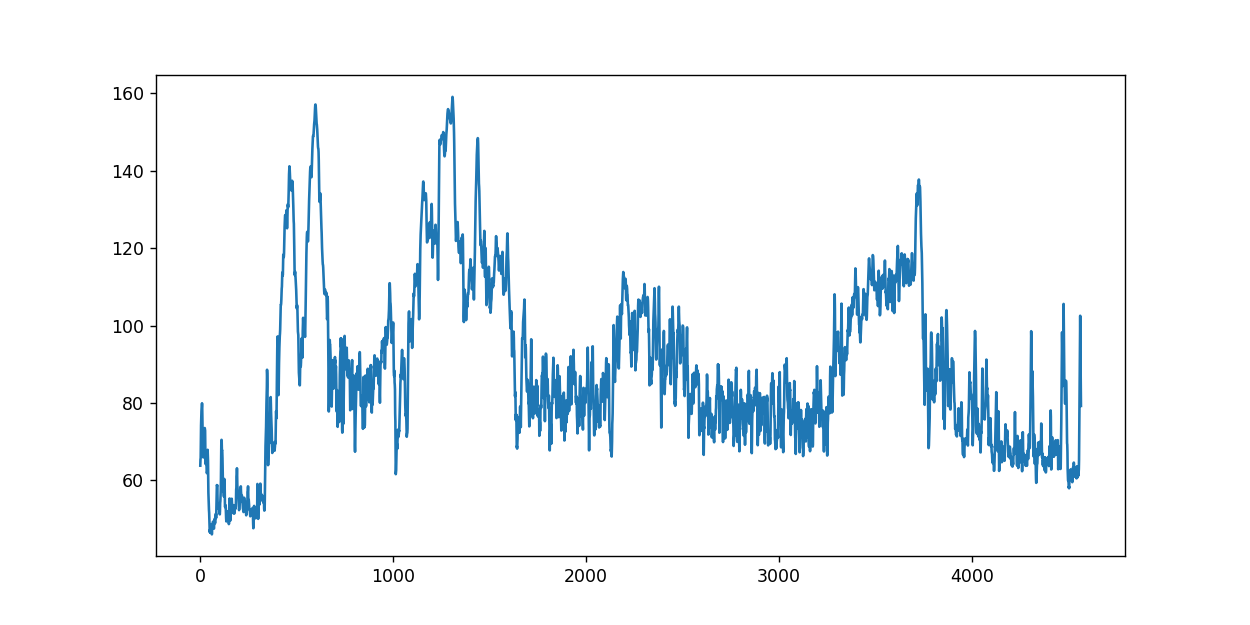

9136.0 9136.0 9136.0 9136.0 9130


<IPython.core.display.Javascript object>


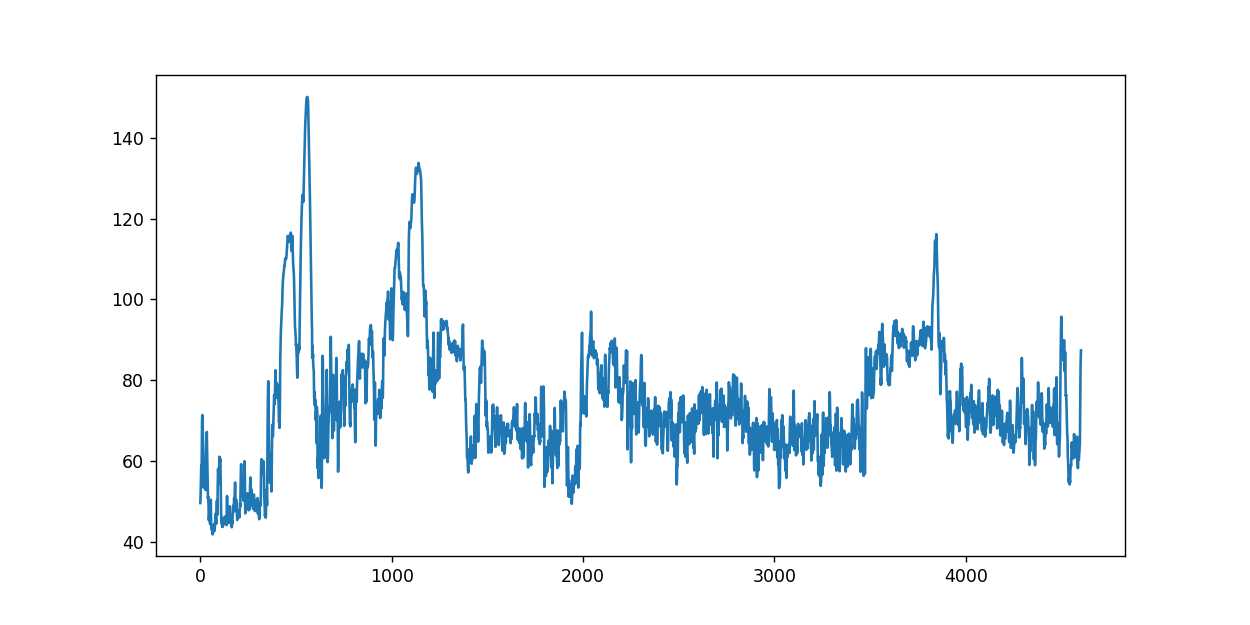

9212.0 9212.0 9212.0 9212.0 9206


<IPython.core.display.Javascript object>


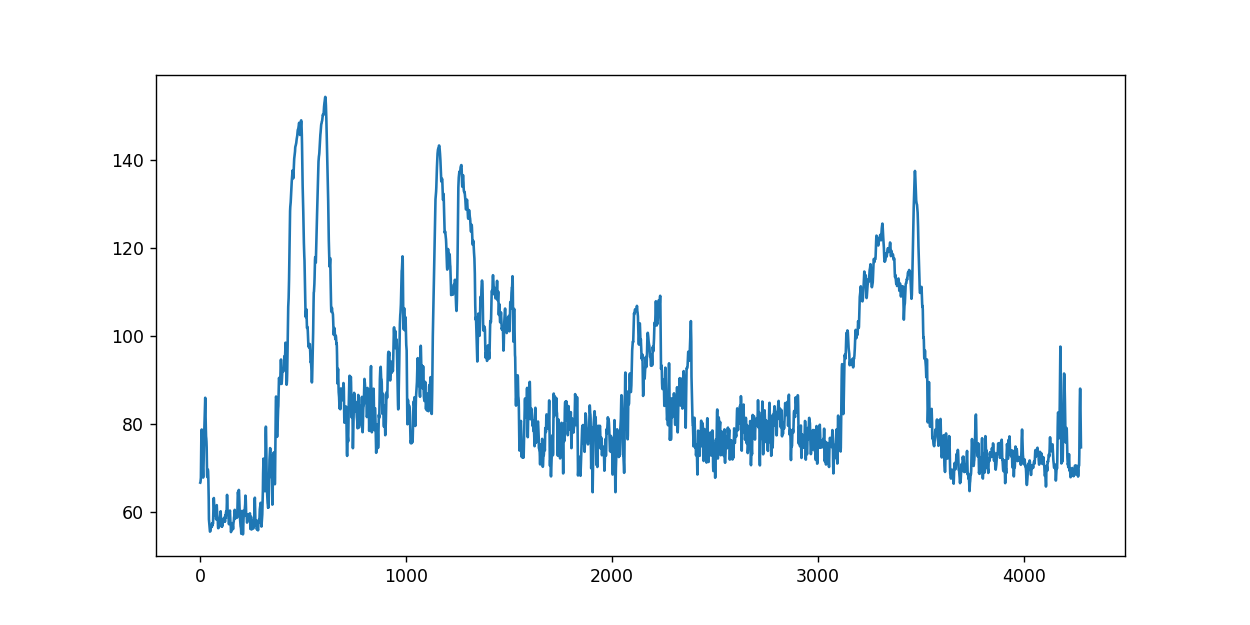

8560.0 8560.0 8560.0 8560.0 8554


<IPython.core.display.Javascript object>


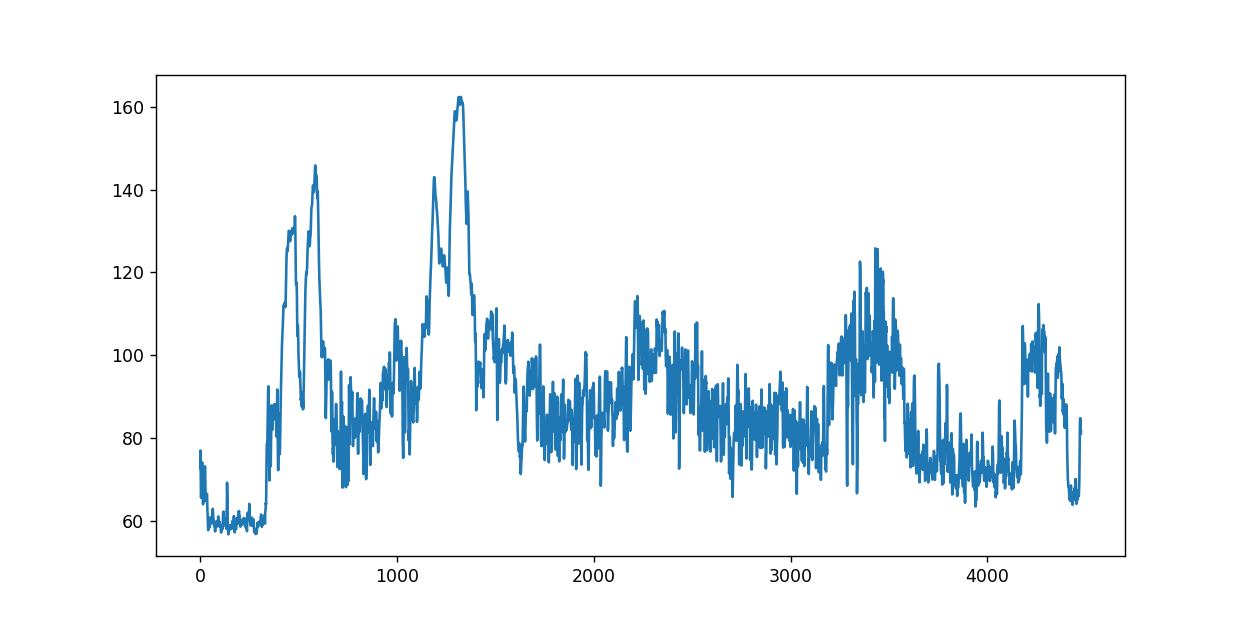

8958.0 8958.0 8958.0 8958.0 8952


<IPython.core.display.Javascript object>


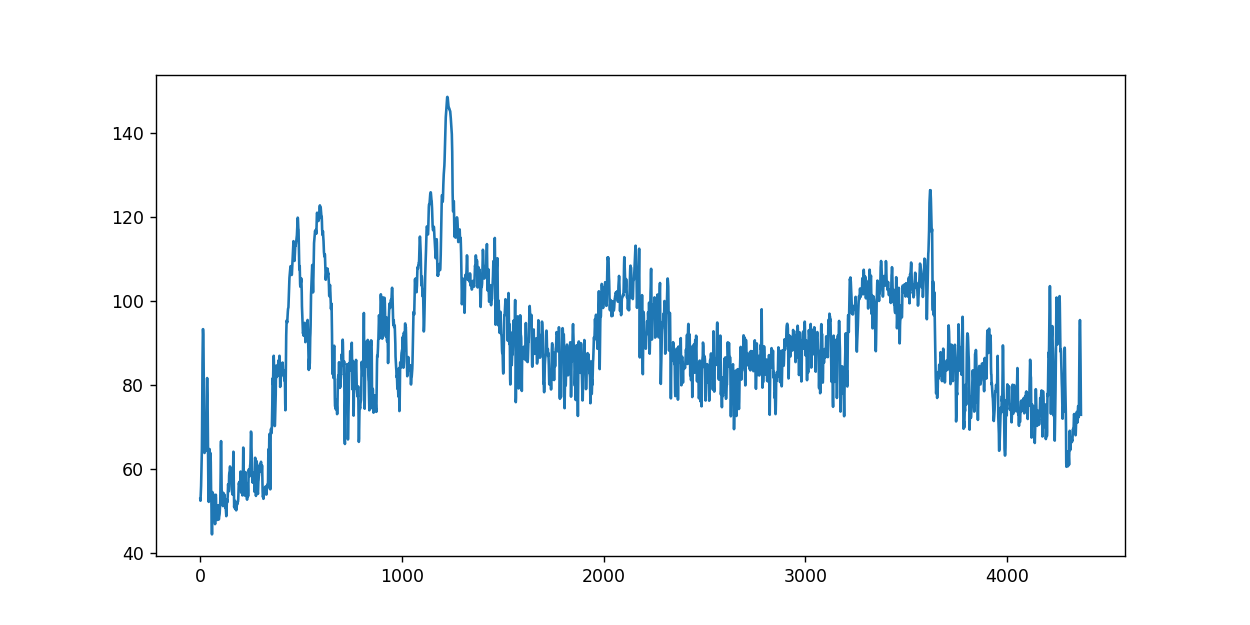

8741.0 8741.0 8741.0 8741.0 8734


<IPython.core.display.Javascript object>


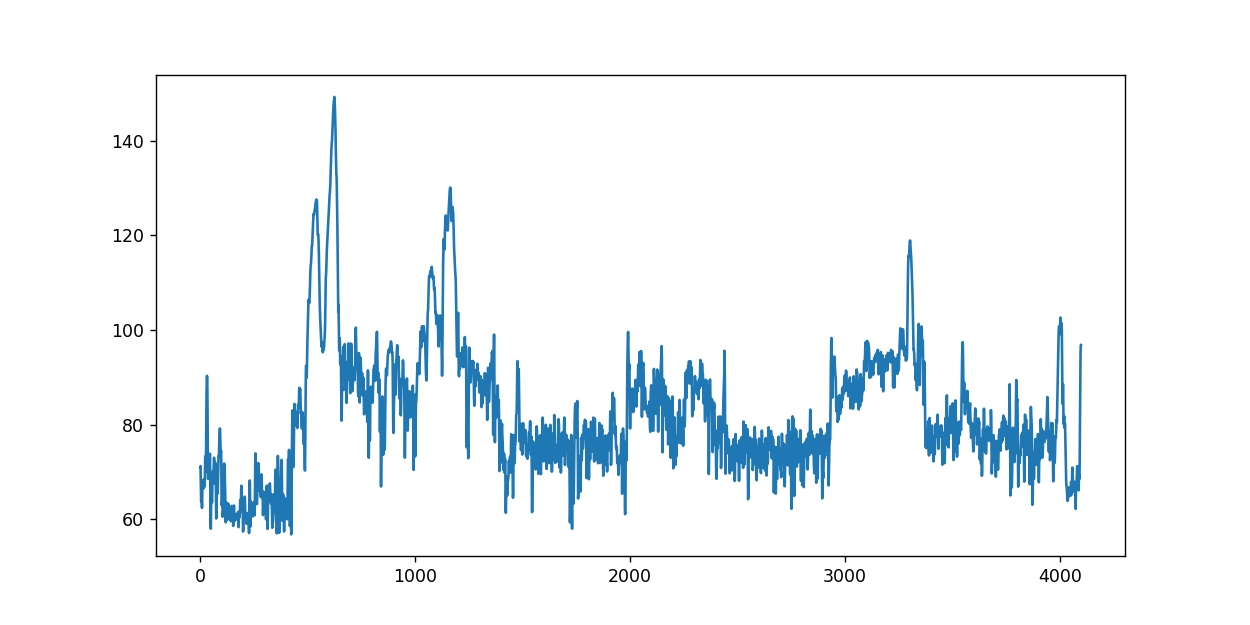

8205.0 8205.0 8205.0 8205.0 8198


<IPython.core.display.Javascript object>


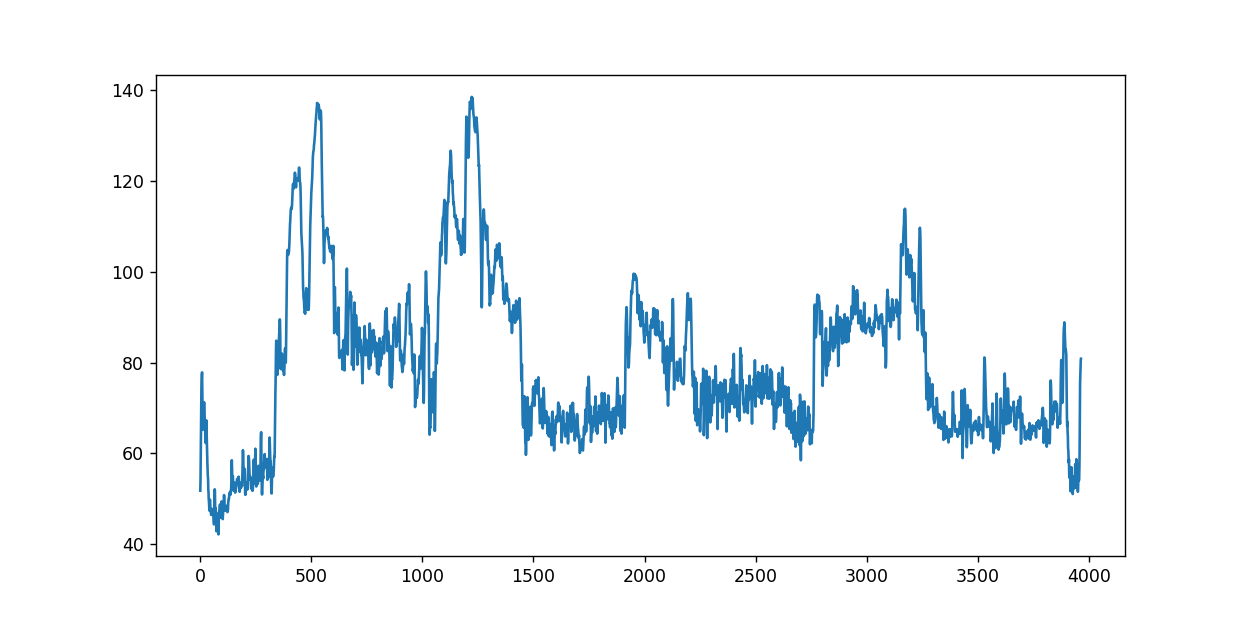

7939.0 7939.0 7939.0 7939.0 7932


<IPython.core.display.Javascript object>


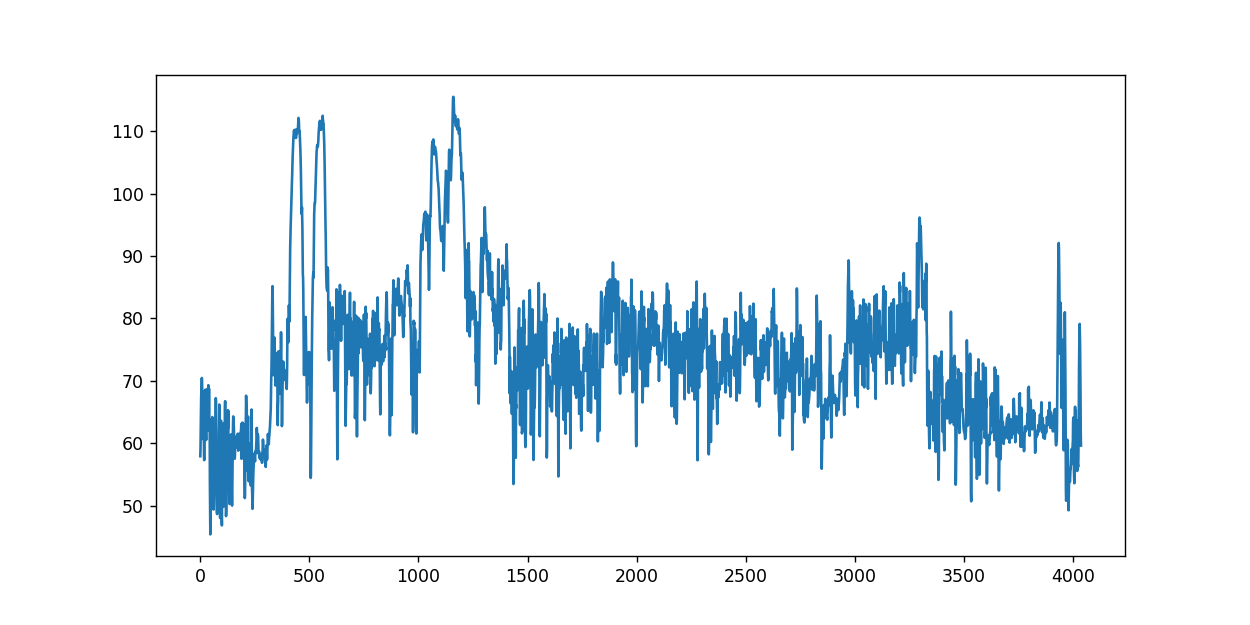

8080.0 8080.0 8080.0 8080.0 8074


<IPython.core.display.Javascript object>


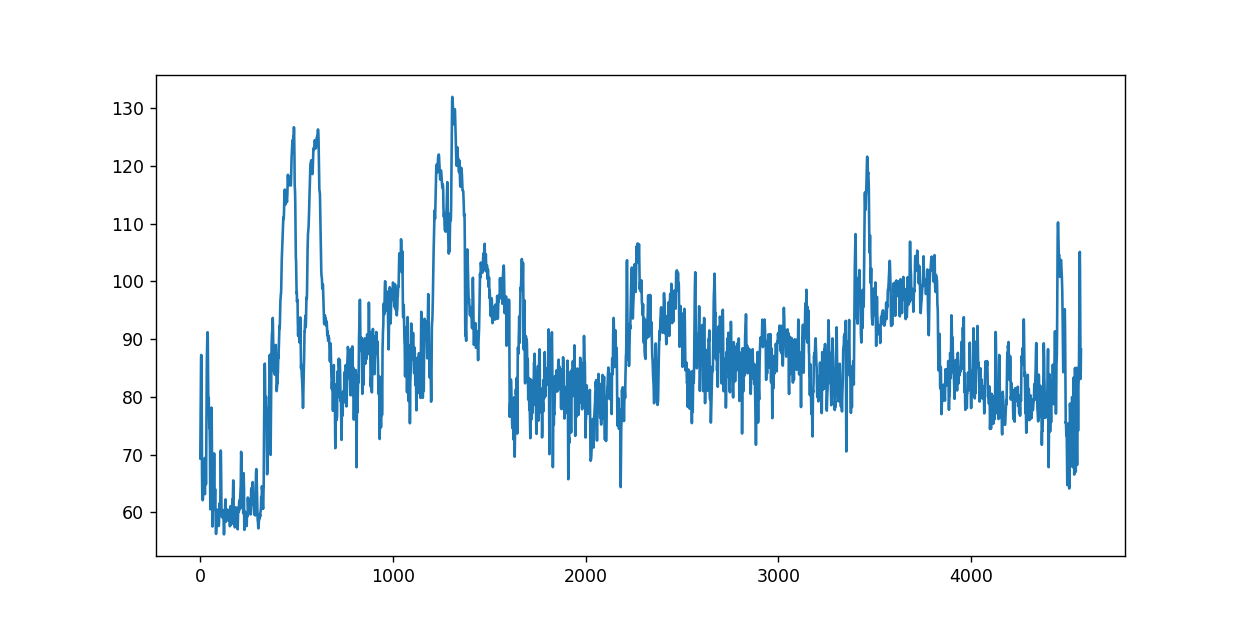

9150.0 9150.0 9150.0 9150.0 9144


<IPython.core.display.Javascript object>


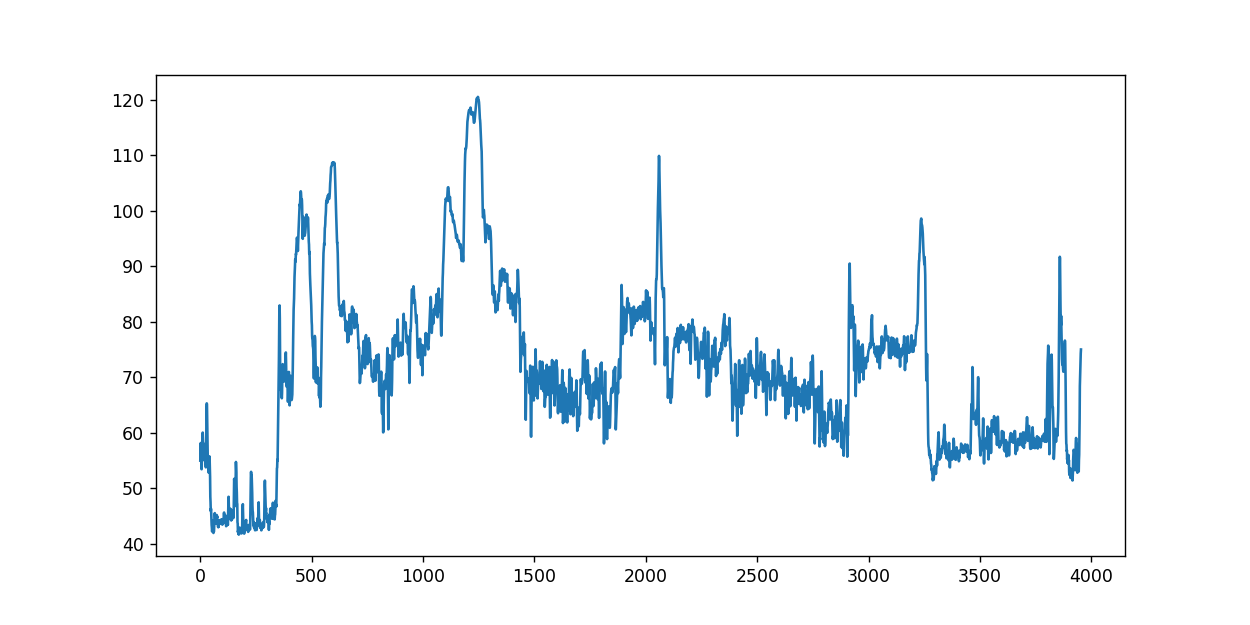

7914.0 7914.0 7914.0 7914.0 7908


'../../affect-recognition/data/PPG_FieldStudy/S13/S13.pkl'

In [13]:
%matplotlib notebook
def get_ecg_rr(ecg_data):
    detectors = Detectors(700)
    rpeaks = detectors.hamilton_detector(ecg_data[:,1])
    ecg_r_ts = ecg_data[np.array(rpeaks),0]
    ecg_rr_ts = ecg_r_ts[1:]
    ecg_rr_sample = np.diff(ecg_r_ts)
    ecg_rr = pd.DataFrame(np.vstack([ecg_rr_ts,ecg_rr_sample]).T,columns=['time','rr'])
    ecg_rr['timestamp'] = ecg_rr['time'].apply(lambda a:datetime.utcfromtimestamp(a))
    return ecg_rr

def bandpass_filter(data,Fs=64,fil_type='ppg'):
    X0 = data[:,1]
    X1 = signal.detrend(X0,axis=0,type='constant')
    X2 = np.zeros((np.shape(X1)[0],data.shape[1]))
    nyq = Fs/2
    b = signal.firls(219,np.array([0,0.3,0.5,3.5,4,nyq]),
                              np.array([0,0,1,1,0,0]),np.array([10,1,1]),fs=nyq*2)
    a = [1]
    X2[:,0] = data[:,0]
    X2[:,1] = signal.filtfilt(b, a, X1)
    return X2

def bandpass_filter_respiration(data,Fs=700,fil_type='ppg'):
    X0 = data[:,1]
    X1 = signal.detrend(X0,axis=0,type='constant')
    X2 = np.zeros((np.shape(X1)[0],data.shape[1]))
    nyq = Fs/2
    b = signal.firls(219,np.array([0,0.03,0.05,2,2.5,nyq]),
                              np.array([0,0,1,1,0,0]),np.array([10,1,1]),fs=nyq*2)
    a = [1]
    X2[:,0] = data[:,0]
    X2[:,1] = signal.filtfilt(b, a, X1)
    return X2

def get_quality_features(ppg_data,ppg_fs=64,window_size=2.5):
    ppg_data_final = []
    n = int(ppg_fs*window_size/2)
    for i in range(n,ppg_data.shape[0]-n,1):
        tmp = []
        tmp.append(ppg_data[i,0])
        tmp.append(ppg_data[i,1])
        sample = ppg_data[(i-n):(i+n),1]
        tmp.append(skew(sample))
        tmp.append(kurtosis(sample))
        tmp.append(iqr(sample))
        f,pxx = signal.welch(sample,fs=ppg_fs,nperseg=len(sample)//2,nfft=10000,axis=0)
        tmp.append(np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]])/np.trapz(pxx))
        ppg_data_final.append(np.array(tmp))
    return np.array(ppg_data_final)


def save_participant_data(filename,ecg_fs = 700,ppg_fs = 64,acc_fs=32,window_size=8,activity_fs=4):
    data = pickle.load(open(filename,'rb'),encoding='latin1')
    ppg_data = data['signal']['wrist']['BVP']
    acc_data = data['signal']['wrist']['ACC']/64
    activity_data = data['activity']
    label_data = data['label']
    plt.figure(figsize=(10,5))
    plt.plot(label_data)
    plt.show()
#     print(data['activity'].shape,acc_data.shape,acc_data.shape[0]/data['activity'].shape[0],data['label'].shape)
#     print(data['signal']['wrist']['ACC'].shape[0]*2,ppg_data.shape)
    ecg_data = data['signal']['chest']['ECG']
    respiration_data = data['signal']['chest']['Resp']
    total_seconds = ppg_data.shape[0]/ppg_fs
    start_ts = datetime.utcnow().timestamp()
    ecg_ts = start_ts + np.arange(0,total_seconds,1/ecg_fs)
    acc_ts = start_ts + np.arange(0,total_seconds,1/acc_fs)
    activity_ts = start_ts + np.arange(0,total_seconds,1/activity_fs)
    activity_data = np.concatenate([activity_ts.reshape(-1,1),activity_data],axis=1)
    acc_data = np.concatenate([acc_ts.reshape(-1,1),acc_data],axis=1)
    respiration_ts = ecg_ts
    respiration_data = np.vstack([respiration_ts,respiration_data.reshape(-1)]).T
    ecg_data = np.vstack([ecg_ts,ecg_data.reshape(-1)]).T
    print(ecg_data.shape[0]/ecg_fs,respiration_data.shape[0]/ecg_fs,
          acc_data.shape[0]/acc_fs,activity_data.shape[0]/activity_fs,
          label_data.shape[0]*2)
#     ecg_rr1 = get_ecg_rr(ecg_data)
#     ecg_rr = ecg_rr1.values
#     ppg_ts = start_ts + np.arange(0,total_seconds,1/ppg_fs)
#     ppg_data = np.vstack([ppg_ts,ppg_data.reshape(-1)]).T
# #     ppg_data = bandpass_filter(ppg_data,Fs=ppg_fs,fil_type='ppg')
#     respiration_data = bandpass_filter_respiration(respiration_data,Fs=ecg_fs,fil_type='ppg')
#     respiration_data[:,0] = respiration_data[:,0]*1000
#     peak_index,valley_index = compute_peak_valley(respiration_data)
#     peak_data = respiration_data[peak_index]
#     valley_data = respiration_data[valley_index]
#     rip_feature = rip_cycle_feature_computation(peak_data,valley_data)[:,:5]
#     rip_feature[:,:2] = rip_feature[:,:2]/1000
#     ppg_data = get_quality_features(ppg_data)
# #     plt.figure(figsize=(10,5))
# # #     plt.plot(ppg_data[:,0],ppg_data[:,1]/np.max(ppg_data[:,1]))
# # #     plt.bar(ppg_data[:,0],ppg_data[:,-1],.95/ppg_fs)
# # #     plt.show()
#     ppg_data = pd.DataFrame(ppg_data,columns=['time','ppg','skew','kurtosis','iqr','relative_power']).dropna().sort_values('time').reset_index(drop=True)
# #     plt.figure(figsize=(10,5))
# #     plt.hist(ppg_data['relative_power'])
# # #     plt.bar(ppg_data[:,0],ppg_data[:,-1],.95/ppg_fs)
# #     plt.show()

# #     ppg_data['timestamp'] = ppg_data['time'].apply(lambda a:datetime.utcfromtimestamp(a))
#     respiration_data[:,0] = respiration_data[:,0]/1000
#     all_data = []
#     for i in range(0,ppg_data.shape[0]-window_size*ppg_fs,window_size*ppg_fs//4):
#         a = ppg_data.loc[i:i+window_size*ppg_fs-1]
# #         print(a['time'].min()-a['time'].max())
#         b = respiration_data[np.where((respiration_data[:,0]>=a['time'].min())&(respiration_data[:,0]<a['time'].max()))[0],1].reshape(-1,1)
#         print(a.shape,b.shape)
#         all_data.append([a['time'].min(),a['time'].max(),
#                          a[['time','ppg','skew','kurtosis','iqr','relative_power']].sort_values('time').reset_index(drop=True),b])
    
    
#     ppg_windows = pd.DataFrame(all_data,columns=['start_time','end_time','data','respiration'])
#     ppg_windows['ecg_rr'] = ppg_windows.apply(lambda a:np.mean(ecg_rr[np.where((ecg_rr[:,0]>=a['start_time'])&(ecg_rr[:,0]<a['end_time']))[0],1]),axis=1)
#     ppg_windows['inspiration_duration'] = ppg_windows.apply(lambda a:np.mean(rip_feature[np.where((rip_feature[:,1]>=a['start_time'])&(rip_feature[:,0]<a['end_time']))[0],2]),axis=1)
#     ppg_windows['expiration_duration'] = ppg_windows.apply(lambda a:np.mean(rip_feature[np.where((rip_feature[:,1]>=a['start_time'])&(rip_feature[:,0]<a['end_time']))[0],3]),axis=1)
#     ppg_windows['respiration_duration'] = ppg_windows.apply(lambda a:np.mean(rip_feature[np.where((rip_feature[:,1]>=a['start_time'])&(rip_feature[:,0]<a['end_time']))[0],4]),axis=1)
#     ppg_windows['acc_window'] = ppg_windows.apply(lambda a: acc_data[np.where((acc_data[:,0]>=a['start_time'])&(acc_data[:,0]<a['end_time']))[0],:],axis=1)
# #     for a in ppg_windows['acc_window'].values:
# #         print(a.shape)

#     print(ppg_windows.shape,ppg_windows.dropna().shape)
# #     plt.figure(figsize=(18,8))
# #     plt.plot(ppg_windows['start_time'],ppg_windows['respiration_duration'])
# #     plt.plot(rip_feature[:,0],rip_feature[:,-1])
# #     plt.show()
#     print(ppg_windows.shape)
#     if not os.path.isdir(output_directory+str(window_size)):
#         os.makedirs(output_directory+str(window_size)+'d')
#     final_path = output_directory+str(window_size)+'d/'
#     participant_name = filename.split('/')[-1]
#     pickle.dump(ppg_windows,open(final_path+participant_name,'wb'))
    
from joblib import Parallel,delayed
output_directory = '../../affect-recognition/data/'
# final = Parallel(n_jobs=10,verbose=2)(delayed(save_participant_data)(f,window_size=4) for f in filelists)
final = [save_participant_data(f,window_size=8) for f in filelists[:10]]
# for filename in filelists:
filelists[0]
#     print(ecg_rr.head(),ppg_data.head())

In [10]:
filelists = ['../../affect-recognition/data/8/'+a for a in os.listdir('../../affect-recognition/data/8/') if a[-1] not in ['s','f']]

In [12]:
for i in range(len(filelists)):
    data = pickle.load(open(filelists[i],'rb'))
    data['acc_window'] = data['acc_window'].apply(lambda a:a[:255])
    data['shape'] = data['respiration'].apply(lambda a:a.shape[0])
    print(data['shape'].unique())
#     plt.hist(data['data'].loc[0]['relative_power'])
#     plt.show()

[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
[5590]
